# Learning a function with PyTorch

In this third lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will teach a neural network to learn a function, e.g. $f(x)=sin(x)$. 

Based on the **Universal Approximation Theorem**, we know that a NN with one hidden layer can approximate any function. We however do not know how deep it should be and how good it is at generalization. We will see that even by making the network deep, we can quite accurately *interpolate* our function between points but we will do poorly when we try to *extrapolate* outside of the domain of the training data. This is a recurring theme in ML, and especially DL, so it is worth being aware of it and what better way than considering a numerical example.

Given enough pairs $(x,f(x))$ we wish the network to be able to give us a correct estimate of $f(x_i)$ on an unseen $x_i$.

Nevertheless, producing point estimates by means of a ML estimator does not provide us with any knowledge of how certain that estimate is. We need something that can help us understand where the model is struggling to predict (i.e., in the extrapolation regime). A variety of techniques have been development in the field of uncertainty quantification (UQ) for ML (and DL) to attach uncertainties to our estimates. See for example https://www.inovex.de/de/blog/uncertainty-quantification-deep-learning/ for a comprehesive description of some of these techniques. In this tutorial we will implement 3 of such techniques, namely:

- UQ by MC-Dropout;
- UQ by Distributional parameter estimation;
- UQ by Deep Ensembles.

In one of the subsequent labs we will further extend the second method for non-gaussian probabilities using Mixture Density Networks (MDNs).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributions as dd

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary

In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

## Create dataset

In [3]:
set_seed(5)

True

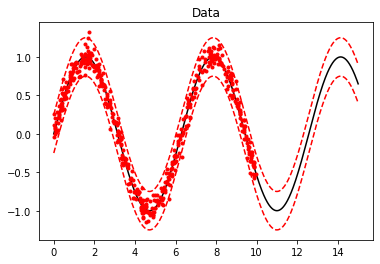

In [4]:
ntrain = 64*8
ntest = 1000
sigma = 0.1 # noise standard deviation

xtrain = torch.rand(ntrain) * 10
xtest = torch.linspace(0, 15, ntest)
ε = sigma * torch.randn(xtrain.shape[0])

ytrain = torch.sin(xtrain) + ε
ytest = torch.sin(xtest)

plt.figure()
plt.plot(xtest, ytest, 'k')
plt.plot(xtrain, ytrain, '.r')
plt.plot(xtest, ytest+2.5*sigma, '--r')
plt.plot(xtest, ytest-2.5*sigma, '--r')
plt.title('Data');

In [5]:
train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
ypreds, ystds = {}, {}

## Deterministic Network

In [7]:
class DeepNetwork(nn.Module):
    def __init__(self, I, H, O, drop=0.3):
        super(DeepNetwork, self).__init__()
        self.net =  nn.Sequential(
            nn.Linear(I, H[0], bias=True),
            nn.ReLU(),
            nn.Linear(H[0], H[1], bias=True),
            nn.ReLU(),
            nn.Linear(H[1], O, bias=True))
        
    def forward(self, x):
        return self.net(x)

In [8]:
model = DeepNetwork(1, [20, 50], 1)
model

DeepNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

Epoch: 500, Loss: 0.018137481878511608
Epoch: 1000, Loss: 0.005439034081064165
Epoch: 1500, Loss: 0.0017318251921096817
Epoch: 2000, Loss: 0.0015141169860726222
Epoch: 2500, Loss: 0.002323462729691528
Epoch: 3000, Loss: 0.0013985819241497666
Epoch: 3500, Loss: 0.0012471717200241983
Epoch: 4000, Loss: 0.0012265347613720223
Epoch: 4500, Loss: 0.001730773423332721


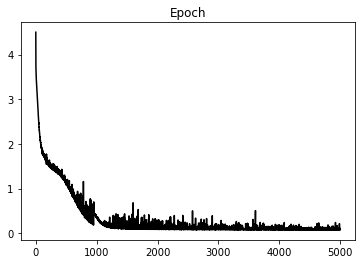

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()
n_epochs = 5000

model.train()
loss_hist = []
for epoch in range(n_epochs):
    total_loss = 0.
    for X, y in train_loader:
        optimizer.zero_grad()
        yest = model(X.view(X.shape[0], 1)).squeeze()
        loss = criterion(yest, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)
    if epoch % (n_epochs//10) == 0:
        print(f'''Epoch: {epoch}, Loss: {total_loss / X.size(0)}''')
        
plt.figure()
plt.plot(loss_hist, 'k')
plt.title('Epoch');

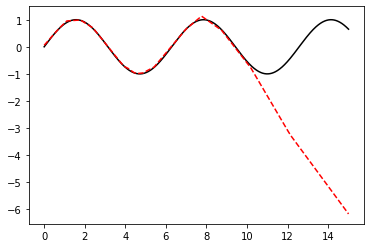

In [10]:
# Prediction
ypred = model(xtest.view(xtest.shape[0], 1)) 
ypreds['Deterministic'] = ypred

plt.figure()
plt.plot(xtest, ytest, 'k')
plt.plot(xtest, ypred.detach().numpy(), '--r');

## Network with Dropout UQ

In [11]:
class DeepDropNetwork(nn.Module):
    def __init__(self, I, H, O, drop=0.3):
        super(DeepDropNetwork, self).__init__()
        self.net =  nn.Sequential(
            nn.Linear(I, H[0], bias=True),
            nn.Dropout(p=drop),
            nn.ReLU(),
            nn.Linear(H[0], H[1], bias=True),
            nn.Dropout(p=drop),
            nn.ReLU(),
            nn.Linear(H[1], O, bias=True))
        
    def forward(self, x):
        return self.net(x)

In [12]:
model = DeepDropNetwork(1, [20, 50], 1, drop=0.01)
model

DeepDropNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Dropout(p=0.01, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Dropout(p=0.01, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

Epoch: 500, Loss: 0.013039052835665643
Epoch: 1000, Loss: 0.00472849074867554
Epoch: 1500, Loss: 0.005624776880722493
Epoch: 2000, Loss: 0.002596722508314997
Epoch: 2500, Loss: 0.003190627525327727
Epoch: 3000, Loss: 0.0023788637336110696
Epoch: 3500, Loss: 0.002716010043513961
Epoch: 4000, Loss: 0.002024296612944454
Epoch: 4500, Loss: 0.0019716435781447217


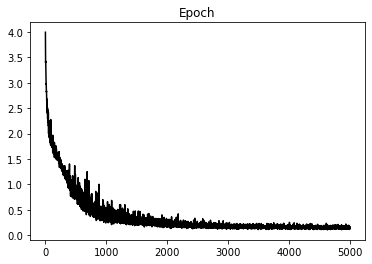

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()
n_epochs = 5000

model.train()
loss_hist = []
for epoch in range(n_epochs):
    total_loss = 0.
    for X, y in train_loader:
        optimizer.zero_grad()
        yest = model(X.view(X.shape[0], 1)).squeeze() 
        loss = criterion(yest, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)
    if epoch % (n_epochs//10) == 0:
        print(f'''Epoch: {epoch}, Loss: {total_loss / X.size(0)}''')

plt.figure()
plt.plot(loss_hist, 'k')
plt.title('Epoch');

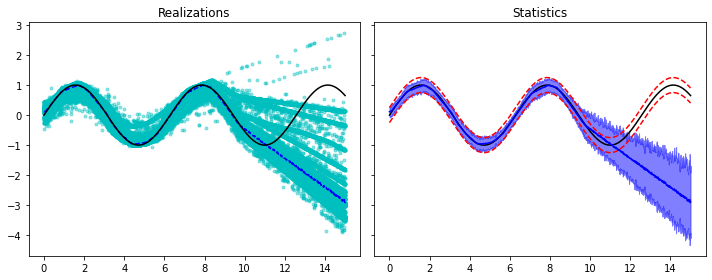

In [14]:
nreals = 400
yreals = np.hstack([model(xtest.view(xtest.shape[0], 1)).detach().numpy() for _ in range(nreals)])

ypred = yreals.mean(axis=1)
ystd = yreals.std(axis=1)
ypreds['Dropout'] = ypred
ystds['Dropout'] = ystd

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axs[0].plot(xtest, yreals, '.c', alpha=0.4)
axs[0].plot(xtest, ypred, '--b')
axs[0].plot(xtest, ytest, 'k')
axs[0].set_title('Realizations')
axs[1].plot(xtest, ytest, 'k')
axs[1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1].plot(xtest, ypred, 'b')
axs[1].fill_between(xtest, ypred - 2.5*ystd, ypred + 2.5*ystd,
                    alpha=0.5, color='b')
axs[1].set_title('Statistics')
fig.tight_layout();

## Network with Distributional parameter UQ

In [15]:
model = DeepNetwork(1, [20, 50], 2)
model

DeepNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
n_epochs = 5000

model.train()
loss_hist = []
for epoch in range(n_epochs):
    total_loss = 0.
    for X, y in train_loader:
        optimizer.zero_grad()
        yest = model(X.view(X.shape[0], 1)) 
        yestdistr = dd.Normal(yest[:, 0], torch.exp(yest[:, 1]))
        loss = -torch.mean(yestdistr.log_prob(y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)
    if epoch % (n_epochs//10) == 0:
        print(f'''Epoch: {epoch}, Loss: {total_loss / X.size(0)}''')

Epoch: 500, Loss: 0.07535286992788315
Epoch: 1000, Loss: -0.009533694217680022
Epoch: 1500, Loss: -0.007467628107406199
Epoch: 2000, Loss: -0.02199850679608062
Epoch: 2500, Loss: -0.029194160480983555
Epoch: 3000, Loss: -0.03478912357240915
Epoch: 3500, Loss: -0.030513074962073006
Epoch: 4000, Loss: -0.07629355136305094
Epoch: 4500, Loss: -0.0612901970744133


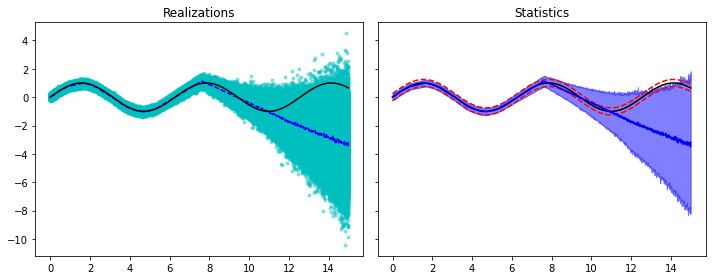

In [17]:
nreals = 400
yest = model(xtest.view(xtest.shape[0], 1))
mu, sig = yest[:, 0], torch.exp(yest[:, 1])
ydistr = dd.Normal(mu, sig)
yreals = ydistr.sample((nreals,)).T

ypred = yreals.mean(axis=1)
ystd = yreals.std(axis=1)
ypreds['DistrPar'] = ypred
ystds['DistrPar'] = ystd

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axs[0].plot(xtest, yreals, '.c', alpha=0.4)
axs[0].plot(xtest, ypred, '--b')
axs[0].plot(xtest, ytest, 'k')
axs[0].set_title('Realizations')
axs[1].plot(xtest, ytest, 'k')
axs[1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1].plot(xtest, ypred, 'b')
axs[1].fill_between(xtest, ypred - 2.5*ystd, ypred + 2.5*ystd,
                    alpha=0.5, color='b')
axs[1].set_title('Statistics')
fig.tight_layout();

## Deep Ensemble Network UQ

Training model 0/10
Epoch: 200, Loss: 0.026282892795279622
Epoch: 400, Loss: 0.015148011618293822
Epoch: 600, Loss: 0.009182786452583969
Epoch: 800, Loss: 0.004896644735708833
Epoch: 1000, Loss: 0.003858573254547082
Epoch: 1200, Loss: 0.0017755793378455564
Epoch: 1400, Loss: 0.0025673154596006498
Epoch: 1600, Loss: 0.001689852841082029
Epoch: 1800, Loss: 0.002415760129224509
Training model 1/10
Epoch: 200, Loss: 0.031036867294460535
Epoch: 400, Loss: 0.01118988310918212
Epoch: 600, Loss: 0.006231894833035767
Epoch: 800, Loss: 0.007903642166638747
Epoch: 1000, Loss: 0.0020763478823937476
Epoch: 1200, Loss: 0.003040392868570052
Epoch: 1400, Loss: 0.0013914888259023428
Epoch: 1600, Loss: 0.0019175065972376615
Epoch: 1800, Loss: 0.0015045069449115545
Training model 2/10
Epoch: 200, Loss: 0.025232989341020584
Epoch: 400, Loss: 0.02104116207920015
Epoch: 600, Loss: 0.0153970931423828
Epoch: 800, Loss: 0.006649000628385693
Epoch: 1000, Loss: 0.008238417998654768
Epoch: 1200, Loss: 0.008736363

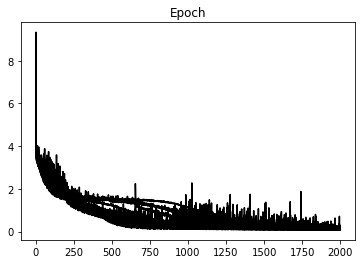

In [18]:
criterion = torch.nn.MSELoss()
n_epochs = 2000
n_models = 10

models = []
loss_hists = []
for i in range(n_models):
    print(f'Training model {i}/{n_models}')
    model = DeepNetwork(1, [20, 50], 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

    model.train()
    loss_hist = []
    for epoch in range(n_epochs):
        total_loss = 0.
        for X, y in train_loader:
            optimizer.zero_grad()
            yest = model(X.view(X.shape[0], 1)).squeeze()
            loss = criterion(yest, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_hist.append(total_loss)
        if epoch % (n_epochs//10) == 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X.size(0)}')
    loss_hists.append(loss_hist)
    models.append(model)
    
plt.figure()
plt.plot(np.array(loss_hists).T, 'k')
plt.title('Epoch');

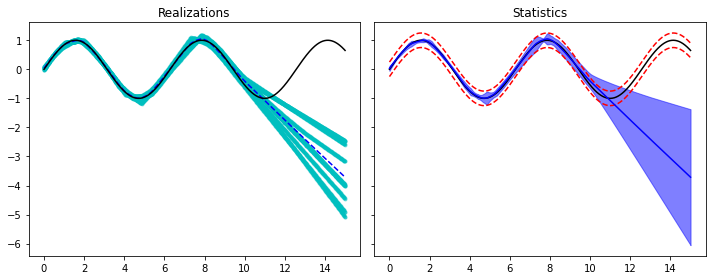

In [19]:
# Prediction
yreals = np.hstack([model(xtest.view(xtest.shape[0], 1)).detach().numpy() for model in models])

ypred = yreals.mean(axis=1)
ystd = yreals.std(axis=1)
ypreds['Ensemble'] = ypred
ystds['Ensemble'] = ystd

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axs[0].plot(xtest, yreals, '.c', alpha=0.4)
axs[0].plot(xtest, ypred, '--b')
axs[0].plot(xtest, ytest, 'k')
axs[0].set_title('Realizations')
axs[1].plot(xtest, ytest, 'k')
axs[1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1].plot(xtest, ypred, 'b')
axs[1].fill_between(xtest, ypred - 2.5*ystd, ypred + 2.5*ystd,
                    alpha=0.5, color='b')
axs[1].set_title('Statistics')
fig.tight_layout();

Finally, let's compare the different predictions (and their uncertainties)

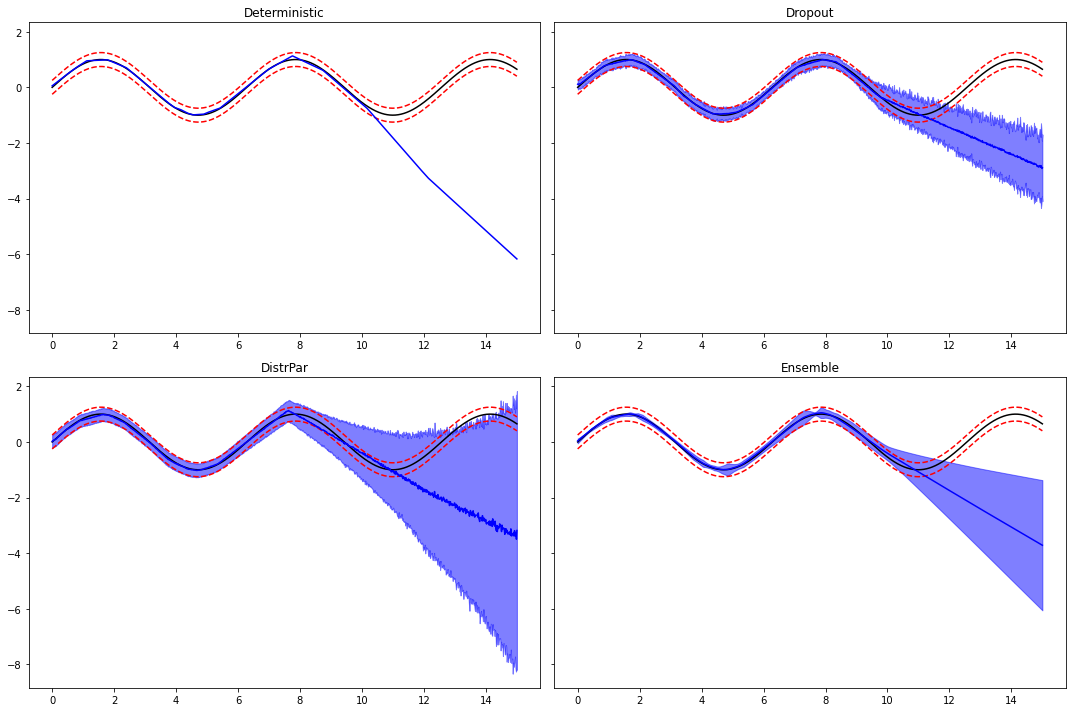

In [27]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(15, 10))
axs[0][0].plot(xtest, ytest, 'k')
axs[0][0].plot(xtest, ytest+2.5*sigma, '--r')
axs[0][0].plot(xtest, ytest-2.5*sigma, '--r')
axs[0][0].plot(xtest, ypreds['Deterministic'].detach().numpy(), 'b')
axs[0][0].set_title('Deterministic')
axs[0][1].plot(xtest, ytest, 'k')
axs[0][1].plot(xtest, ytest+2.5*sigma, '--r')
axs[0][1].plot(xtest, ytest-2.5*sigma, '--r')
axs[0][1].plot(xtest, ypreds['Dropout'], 'b')
axs[0][1].fill_between(xtest, ypreds['Dropout'] - 2.5*ystds['Dropout'], 
                       ypreds['Dropout'] + 2.5*ystds['Dropout'],
                       alpha=0.5, color='b')
axs[0][1].set_title('Dropout')
axs[1][0].plot(xtest, ytest, 'k')
axs[1][0].plot(xtest, ytest+2.5*sigma, '--r')
axs[1][0].plot(xtest, ytest-2.5*sigma, '--r')
axs[1][0].plot(xtest, ypreds['DistrPar'], 'b')
axs[1][0].fill_between(xtest, ypreds['DistrPar'] - 2.5*ystds['DistrPar'], 
                       ypreds['DistrPar'] + 2.5*ystds['DistrPar'],
                       alpha=0.5, color='b')
axs[1][0].set_title('DistrPar')
axs[1][1].plot(xtest, ytest, 'k')
axs[1][1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1][1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1][1].plot(xtest, ypreds['Ensemble'], 'b')
axs[1][1].fill_between(xtest, ypreds['Ensemble'] - 2.5*ystds['Ensemble'], 
                       ypreds['Ensemble'] + 2.5*ystds['Ensemble'],
                       alpha=0.5, color='b')
axs[1][1].set_title('Ensemble')
fig.tight_layout();t